In [ ]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path
import pandas as pd

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [ ]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v6/")
# coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/val.json")
# out_dir = Path("./notebook_results/a549_ccp_vim/test_data_v6/")
# out_dir = Path("./notebook_results/a549_ccp_vim/test_data_tmp/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


In [ ]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


In [ ]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# # for testing
# single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [ ]:
len(single_cells)

save a list of single cell objects

In [ ]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [ ]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


In [ ]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


In [ ]:
sample_sc = single_cells[cell_id]
sample_sc.meta

In [ ]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)

for sc in single_cells:
    assert sc.timeframe in seg_data.time2url
    sc.mask_dataset = seg_data

## Generate Synthetic Undersegmentation data

In [ ]:
sc1 = single_cells[10]
sc2 = single_cells[1]

padding=20
fig, axes = plt.subplots(2, 3, figsize=(10, 5))
sc1.show(padding=padding, ax=axes[0][0])
sc1.show_contour_img(padding=padding, ax=axes[0][1])
sc1.show_contour_mask(padding=padding, ax=axes[0][2])
sc2.show(padding=padding, ax=axes[1][0])
sc2.show_contour_img(padding=padding, ax=axes[1][1])
sc2.show_contour_mask(padding=padding, ax=axes[1][2])

In [ ]:
from livecell_tracker.core.datasets import SingleImageDataset


def check_contour_in_boundary(contour, boundary):
    return np.all(contour >= 0) and np.all(contour < boundary)


def adjust_contour_to_bounds(contour, bounds):
    bounds = np.array(bounds)
    if not check_contour_in_boundary(contour, bounds):
        contour = contour.copy()
        contour[contour < 0] = 0
        contour = np.where(contour >= bounds, bounds - 1, contour)
    return contour

def shift_contour_randomly(sc_center, contour, bounds):
    random_center = np.random.randint(low=0, high=bounds, size=2)
    shift = random_center - sc_center
    shift = shift.astype(int)
    contour_shifted = contour + shift
    return random_center, contour_shifted, shift

def compute_two_contours_min_distance(contour1, contour2):
    min_dist = np.inf
    for p1 in contour1:
        for p2 in contour2:
            dist = np.linalg.norm(p1 - p2)
            if dist < min_dist:
                min_dist = dist
    return min_dist


def _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=False):
    if not in_place:
        new_img = new_img.copy()
    sc_ori_space_pixel_xy_arr = np.array(new_sc_mask.nonzero()).T - shift
    sc_ori_space_pixel_xy_arr[sc_ori_space_pixel_xy_arr < 0] = 0
    new_img[new_sc_mask] = sc.get_contour_img()[sc_ori_space_pixel_xy_arr[:, 0], sc_ori_space_pixel_xy_arr[:, 1]]
    return new_img
    

def add_sc_to_img(sc, new_img, mask, bg_img, in_place=False, mask_inplace=True, fix_sc_pos=False):
    bg_shape = np.array(bg_img.shape)
    sc_prop = sc.compute_regionprops()
    sc_contour_coords = sc.get_contour_coords_on_crop().astype(int)
    if fix_sc_pos:
        sc_new_center = sc_prop.centroid
        sc_new_contour = sc_contour_coords
        shift = 0
    else:
        sc_new_center, sc_new_contour, shift = shift_contour_randomly(sc_prop.centroid, sc_contour_coords, bounds=bg_shape)
    sc_new_contour = adjust_contour_to_bounds(sc_new_contour, bg_shape)
    new_sc_mask = SingleCellStatic.gen_contour_mask(sc_new_contour, bg_img, bbox=None)
    new_sc_mask_bool = new_sc_mask > 0 # convert to bool
    new_img = _add_sc_to_img_helper(sc, new_img, new_sc_mask, shift, in_place=in_place)

    if mask_inplace:
        mask = mask.copy()
    mask[new_sc_mask_bool] = True
    return new_img, sc_new_contour, mask, shift

def combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=1.5, fix_sc1=False):
    def _gen_empty_bg_img():
        sc1_shape = sc1.get_img_crop().shape
        sc2_shape = sc2.get_img_crop().shape
        bg_shape = np.array([max(sc1_shape[0], sc2_shape[0]), max(sc1_shape[1], sc2_shape[1])])
        bg_shape = (bg_shape * bg_scale).astype(int)
        bg_img = np.zeros(shape=bg_shape)
        return bg_img
    
    if bg_img is None:
        bg_img = _gen_empty_bg_img()

    bg_shape = np.array(bg_img.shape)
    new_img = bg_img.copy()
    new_mask = np.zeros(shape=bg_shape, dtype=bool)

    _, sc1_new_contour, sc1_new_mask, shift1 = add_sc_to_img(sc1, new_img, bg_img=bg_img, mask=new_mask, in_place=True, fix_sc_pos=fix_sc1)
    _, sc2_new_contour, sc2_new_mask, shift2 = add_sc_to_img(sc2, new_img, bg_img=bg_img, mask=new_mask, in_place=True)

    new_sc1 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc1_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc1_new_mask))
    new_sc2 = SingleCellStatic(timeframe=SingleImageDataset.DEFAULT_TIME, contour=sc2_new_contour, img_dataset=SingleImageDataset(new_img), mask_dataset=SingleImageDataset(sc2_new_mask))
    return new_sc1, new_sc2

# has_overlap = np.any(new_sc1_mask & new_sc2_mask)
# print(has_overlap)
# fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# ax = axes[0][0]
# ax.imshow(new_sc1_mask | new_sc2_mask)
# ax = axes[0][1]
# ax.imshow(new_img)
bg_scale = 3.0

def viz_check_combined_sc_result(sc1, sc2):
    fig, axes = plt.subplots(1, 8, figsize=(18, 5))
    ax_idx = 0
    ax = axes[ax_idx]
    sc1.show_whole_img(ax=ax)
    ax.set_title("sc1 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show(ax=ax)
    ax.set_title("sc1 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_mask(ax=ax, padding=20)
    ax.set_title("sc1 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc1.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc1 contour img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_whole_img(ax=ax)
    ax.set_title("sc2 whole img")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show(ax=ax, crop=True)
    ax.set_title("sc2 img crop")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_mask(ax=ax, padding=20)
    ax.set_title("sc2 mask")
    ax_idx += 1

    ax = axes[ax_idx]
    sc2.show_contour_img(ax=ax, padding=20)
    ax.set_title("sc2 contour img")
    ax_idx += 1

    plt.show()

for i in range(4):
    new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None)
    viz_check_combined_sc_result(new_sc1, new_sc2)

# for i in range(4):
#     new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, fix_sc1=True)
#     viz_check_combined_sc_result(new_sc1, new_sc2)

In [ ]:
viz_check_combined_sc_result(new_sc1, new_sc2)

In [ ]:
def gen_synthetic_overlap_scs(sc1, sc2, max_overlap_percent=0.2, bg_scale=2.0, fix_sc1=False, min_reserved_area_percent = 0.7, max_try=1000):
    # TODO: optimize in the future via computational geometry; now simply use monte carlo for generating required synthetic data
    is_success = False
    counter = 0
    while not is_success and counter < max_try:
        is_success = True
        new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=None, bg_scale=bg_scale, fix_sc1=fix_sc1)
        # check overlap
        overlap_mask = np.logical_and(new_sc1.get_mask(), new_sc2.get_mask())
        overlap_percent = float(np.sum(overlap_mask)) / min(np.sum(new_sc1.get_mask()), np.sum(new_sc2.get_mask()))
        if overlap_percent > 0 and overlap_percent < max_overlap_percent:
            pass
        else:
            is_success = False

        # check area percent to prevent scs that are too small
        area = float(np.sum((new_sc1.get_contour_mask()>0).flatten())) + np.sum((new_sc2.get_contour_mask()>0).flatten())
        old_area = float(np.sum((sc1.get_contour_mask()>0).flatten())) + np.sum((sc2.get_contour_mask()>0).flatten())
        if (area / old_area)  < min_reserved_area_percent:
            is_success = False
        counter += 1

    return new_sc1, new_sc2, overlap_percent, is_success



# check results
for i in tqdm(range(4)):
    new_sc1, new_sc2, _, is_success = gen_synthetic_overlap_scs(sc1, sc2)
    viz_check_combined_sc_result(new_sc1, new_sc2)

In [ ]:
sc1

### Generate synthetic non-overlapping underseg cells 

In [ ]:
def compute_distance_by_contour(sc1, sc2):
    # compute distance between two scs by their contour
    c1, c2 = sc1.get_contour(), sc2.get_contour()
    
    # make two contours have the same length
    if c1.shape[0] != c2.shape[0]:
        min_len = min(c1.shape[0], c2.shape[0])
        c1 = c1[:min_len]
        c2 = c2[:min_len]
    dist = np.linalg.norm(c1 - c2, axis=1)
    min_dist = np.min(dist)
    return min_dist

sc3 = single_cells[3]
# fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# sc1.show_contour_img(ax=axes[0], padding=10000)
# sc2.show_contour_img(ax=axes[1], padding=10000)
# sc3.show_contour_img(ax=axes[2], padding=10000)


compute_distance_by_contour(sc1, sc2), compute_distance_by_contour(sc1, sc3), compute_distance_by_contour(sc2, sc3)

In [ ]:
def gen_gauss_sc_bg(sc: SingleCellStatic, shape):
    """generate background for sc by gaussian noise"""
    img = sc.get_img()
    mask = sc.get_mask().astype(bool)
    bg_mask = np.logical_not(mask)

    # compute gauss distribution of background pixels
    pixels = img[bg_mask].flatten()
    mean = np.mean(pixels)
    std = np.std(pixels)
    res_bg_img = np.random.normal(0, 1, shape)
    res_bg_img = res_bg_img * std + mean
    return res_bg_img

plt.imshow(gen_gauss_sc_bg(sc1, (512, 512)))
    

In [ ]:
def gen_sc_bg_crop(sc, shape):
    """generate background for sc by cropping from the sc's image. For regions belong to single cells, remove cells and fill with gaussian noise."""
    img = sc.get_img()
    mask = sc.get_mask().astype(bool)
    bg_mask = np.logical_not(mask)
    if not (img.shape[0] >= shape[0] and img.shape[1] >= shape[1]):
        print("Shape of sc is smaller than the required shape, return None...")
        return None
    # compute gauss distribution of background pixels
    pixels = img[bg_mask].flatten()
    mean = np.mean(pixels)
    std = np.std(pixels)

    # randomly crop a region from the large image
    bounds = np.array(img.shape) - np.array(shape)
    crop_row, crop_col = np.random.randint(low=0, high=bounds, size=2)
    res_bg_img = np.array(img[crop_row:crop_row+shape[0], crop_col:crop_col+shape[1]])
    res_bg_mask = np.array(bg_mask[crop_row:crop_row+shape[0], crop_col:crop_col+shape[1]])

    res_bg_img[~res_bg_mask] = np.random.normal(0, 1, np.sum(~res_bg_mask)) * std + mean
    return res_bg_img


plt.imshow(gen_sc_bg_crop(sc1, (512, 512)))

In [ ]:

def gen_synthetic_nonoverlap_scs(sc1: SingleCellStatic, sc2: SingleCellStatic, min_dist=-np.inf, max_dist=np.inf, min_reserved_area_percent = 0.7, bg_scale=3.0, fix_sc1=False, max_try=1000, gen_bg_func=None):
    is_success = False
    counter = 0
    sc1_shape = sc1.get_contour_mask().shape
    sc2_shape = sc2.get_contour_mask().shape
    max_shape = np.max(np.array([sc1_shape, sc2_shape]), axis=0) * bg_scale

    syn_bg_shape = (int(max_shape[0]), int(max_shape[1]))
    while not is_success and counter < max_try:
        is_success = True
        bg_img = None
        if gen_bg_func is not None:
            bg_img = gen_bg_func(sc1, shape=syn_bg_shape)
            if bg_img is None:
                is_success = False
                continue

        # TODO: we can improve this function by replacing monte carlo method
        # TODO: calculate distance between two scs and move two scs together can satisfy the conditions efficiently
        new_sc1, new_sc2 = combine_two_scs_monte_carlo(sc1, sc2, bg_img=bg_img, bg_scale=bg_scale, fix_sc1=fix_sc1)
        # check overlap
        overlap_percent = new_sc1.compute_iou(new_sc2)
        if overlap_percent > 1e-5:
            is_success = False
        dist = compute_distance_by_contour(new_sc1, new_sc2)
        if dist < min_dist or dist > max_dist:
            is_success = False

        # check area percent to prevent scs that are too small
        area = float(np.sum((new_sc1.get_contour_mask()>0).flatten())) + np.sum((new_sc2.get_contour_mask()>0).flatten())
        old_area = float(np.sum((sc1.get_contour_mask()>0).flatten())) + np.sum((sc2.get_contour_mask()>0).flatten())
        if (area / old_area)  < min_reserved_area_percent:
            is_success = False

        print("counter: {}, overlap: {}, dist: {}, %%area: {}".format(counter, overlap_percent, dist, area / old_area))
        counter += 1
    return new_sc1, new_sc2, dist, is_success

# check results
min_dist = 30
max_dist = 100
for i in tqdm(range(2)):
    new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop, min_dist=min_dist, max_dist=max_dist)
    viz_check_combined_sc_result(new_sc1, new_sc2)

for i in tqdm(range(2)):
    new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=min_dist, max_dist=max_dist)
    viz_check_combined_sc_result(new_sc1, new_sc2)

counter: 0, overlap: 0.0, dist: 161.82088863926066, %%area: 0.9411348521296166
counter: 1, overlap: 0.0, dist: 61.07372593840988, %%area: 0.8942974388000566
counter: 2, overlap: 0.0, dist: 125.2078272313676, %%area: 1.0005660110372152


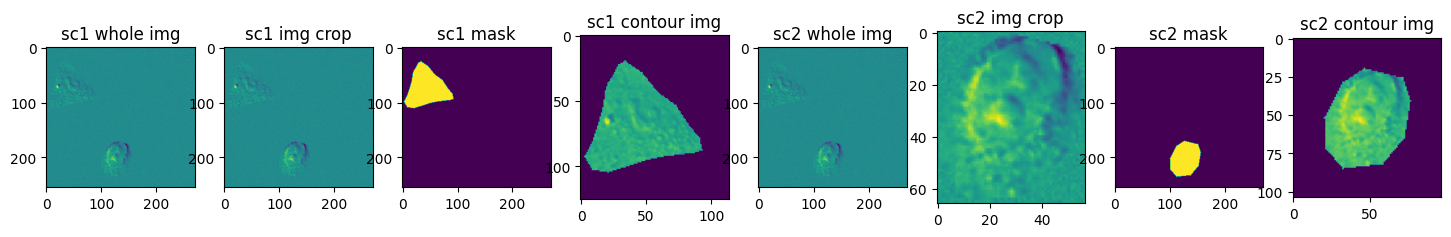

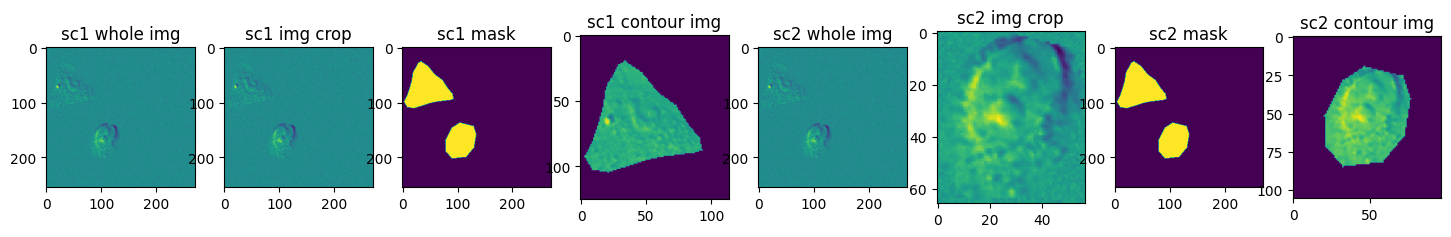

In [41]:
def move_two_syn_scs_close_or_apart(sc1: SingleCellStatic, sc2: SingleCellStatic, dist, bg_img, inplace=False, apart=False):
    if not inplace:
        sc1 = sc1.copy()
        sc2 = sc2.copy()
    overlap = sc1.compute_overlap_percent(sc2)
    img_space_dims = bg_img.shape
    assert overlap <= 1e-5, "Two scs should not overlap"

    # move sc2 toward sc1
    norm_vec = (sc1.get_center(crop=False) - sc2.get_center(crop=False))
    norm_vec = norm_vec / np.linalg.norm(norm_vec)
    pos_offset_vec = (norm_vec * dist).astype(int)
    if apart:
        pos_offset_vec = -pos_offset_vec
    
    new_contour = sc2.get_contour() + pos_offset_vec
    new_contour = adjust_contour_to_bounds(new_contour, img_space_dims)
    tmp_sc2 = sc2.copy()
    tmp_sc2.update_contour(new_contour)

    new_img = bg_img.copy()
    new_mask = np.zeros(bg_img.shape, dtype=np.uint8)
    sc1_bbox, sc2_bbox = sc1.get_bbox(), tmp_sc2.get_bbox()
    new_sc_bbox = tmp_sc2.get_bbox()
    projected_new_sc_bbox = (new_sc_bbox.reshape(2, 2) - pos_offset_vec).flatten()

    # update datasets
    # TODO: consider if we have more datasets in single cell objects?
    new_img[sc1_bbox[0]:sc1_bbox[2], sc1_bbox[1]:sc1_bbox[3]] = sc1.get_img_crop()
    new_img[new_sc_bbox[0]:new_sc_bbox[2], new_sc_bbox[1]:new_sc_bbox[3]] = sc2.get_img_crop(bbox=projected_new_sc_bbox)
    new_mask[sc1_bbox[0]:sc1_bbox[2], sc1_bbox[1]:sc1_bbox[3]] |= sc1.get_mask_crop()
    new_mask[new_sc_bbox[0]:new_sc_bbox[2], new_sc_bbox[1]:new_sc_bbox[3]] |= sc2.get_mask_crop(bbox=projected_new_sc_bbox)
    
    # set image datasets of scs
    sc1.img_dataset = SingleImageDataset(new_img)
    sc1.mask_dataset = SingleImageDataset(new_mask)

    sc2.img_dataset = sc1.img_dataset
    sc2.mask_dataset = sc1.mask_dataset
    sc2.update_contour(tmp_sc2.get_contour(), update_bbox=True)
    return sc1, sc2

# for i in tqdm(range(2)):
new_sc1, new_sc2, _, is_success = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=min_dist, max_dist=1000,  min_reserved_area_percent=1)
viz_check_combined_sc_result(new_sc1, new_sc2)
move_two_syn_scs_close_or_apart(new_sc1, new_sc2, dist=40, bg_img=gen_gauss_sc_bg(new_sc1, shape=new_sc1.get_img().shape), inplace=True)
viz_check_combined_sc_result(new_sc1, new_sc2)

In [ ]:
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecell_tracker.core.io_utils import save_tiff
from livecell_tracker.segment.ou_utils import csn_augment_helper, underseg_overlay_gt_masks, gen_aug_diff_mask


check sc areas 
```
for sc in single_cells:
    prop = sc.compute_regionprops()
    assert prop.area > 5
```

In [ ]:
def augment_and_save_merged_sc(sc: SingleCellStatic, scale_factors, scs, img_id, seg_label, syn_id, out_dir):
    # img_crop = sc.get_img_crop()
    # seg_crop = sc.get_mask_crop()

    # Note: do not use get_img_crop() and get_mask_crop() here, because we want to use the original image and mask
    # which are consistent across scs passed in
    img_crop = sc.get_img()
    seg_crop = sc.get_mask()

    syn_underseg_out_dir = out_dir
    raw_out_dir = syn_underseg_out_dir / "raw"
    seg_out_dir = syn_underseg_out_dir / "seg"
    gt_out_dir = syn_underseg_out_dir / "gt"
    gt_label_out_dir = syn_underseg_out_dir / "gt_label_mask"
    augmented_seg_dir = syn_underseg_out_dir / "augmented_seg"
    raw_transformed_img_dir = syn_underseg_out_dir / "raw_transformed_img"
    augmented_diff_seg_dir = syn_underseg_out_dir / "augmented_diff_seg"

    # makedirs
    all_dirs = [syn_underseg_out_dir, raw_out_dir, seg_out_dir, gt_out_dir, gt_label_out_dir, augmented_seg_dir, raw_transformed_img_dir, augmented_diff_seg_dir]
    for directory in all_dirs:
        if not directory.exists():
            print(">>> creating dir: ", directory)
            os.makedirs(directory, exist_ok=True)


    # generate combined gt label mask
    combined_gt_label_mask = sc.get_mask().astype(int)
    for i, tmp_sc in enumerate(scs):
        # mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, tmp_sc.get_mask())
        mask = tmp_sc.get_mask().astype(bool)
        if mask.shape != combined_gt_label_mask.shape:
            print("mask dim: ", mask.shape)
            print("combined_gt_label_mask dim: ", combined_gt_label_mask.shape)
        combined_gt_label_mask[mask] = i + 1

    raw_img_path = raw_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    seg_img_path = seg_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_img_path = gt_out_dir / ("syn-underseg-img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_label_img_path = gt_label_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))

    underseg_train_tuples = []
    augmented_data = []
    filename_pattern = "syn-underseg-img-%d_seg-%d.tif"
    res_dict = csn_augment_helper(img_crop=img_crop, 
        seg_crop=seg_crop, 
        combined_gt_label_mask=combined_gt_label_mask,
        overseg_raw_seg_crop=None,
        overseg_raw_seg_img_path=None,
        scale_factors=scale_factors,
        train_path_tuples=underseg_train_tuples,
        augmented_data=augmented_data,
        img_id=img_id,
        seg_label=syn_id,
        gt_label=-1,
        raw_img_path=raw_img_path,
        seg_img_path=seg_img_path,
        gt_img_path=gt_img_path,
        gt_label_img_path=gt_label_img_path,
        augmented_seg_dir=augmented_seg_dir,
        augmented_diff_seg_dir=augmented_diff_seg_dir,
        filename_pattern=filename_pattern,
        raw_transformed_img_dir=raw_transformed_img_dir,
        df_save_path=syn_underseg_out_dir/"data.csv",
    )
    return res_dict
        
    

In [ ]:
import itertools
from skimage.measure import find_contours
import cv2

def show_cv2_contours(contours, img):
    im = np.expand_dims(img.astype(np.uint8), axis=2).repeat(3, axis=2) 
    for k, _ in enumerate(contours):
        im = cv.drawContours(im, contours, k, (0, 230, 255), 6)
    plt.imshow(im)
    plt.show()

def find_contours_opencv(mask) -> list:
    contours, hierarchy = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contours = list(contours)
    for i, contour in enumerate(contours):
        contour = np.array(contour)
        contour = contour[:, :, ::-1]
        contour = contour.reshape(-1, 2)
        contours[i] = contour
    return contours

def merge_two_scs_overlap(sc1: SingleCellStatic, sc2: SingleCellStatic):
    new_mask = np.logical_or(sc1.get_mask().astype(bool), sc2.get_mask().astype(bool))
    # plt.imshow(new_mask)
    # plt.show()
    # print(np.unique(new_mask))
    # contours = find_contours(new_mask, fully_connected="high")

    contours = find_contours_opencv(new_mask.astype(np.uint8))
    assert len(contours) != 0, "must contain at least one contour"
    if len(contours) > 1:
        print("WARNING: more than one contour found, return merge failure to the caller...")
        return None, False
    new_contour = contours[0]
    res_sc = SingleCellStatic(
        timeframe=SingleImageDataset.DEFAULT_TIME,
        contour=new_contour,
        img_dataset=sc1.img_dataset,
        mask_dataset=SingleImageDataset(new_mask),
    )
    return res_sc, True



def merge_two_scs_nonoverlap(sc1: SingleCellStatic, sc2: SingleCellStatic, max_dilate_iter=998, kernel_shape=(7, 7)):
    new_mask = np.logical_or(sc1.get_mask().astype(bool), sc2.get_mask().astype(bool))

    contours = find_contours_opencv(new_mask.astype(np.uint8))
    assert len(contours) != 0, "must contain at least one contour"
    if len(contours) != 2:
        print("WARNING: #contours should be exactly 2 for merging two cells in non-overlap case, return merge failure to the caller...")
        return None, False

    # dilate until the two contours are merged
    kernel = np.ones(kernel_shape, np.uint8)
    counter = 0
    while len(contours) != 1 and counter < max_dilate_iter:
        new_mask = cv2.dilate(new_mask.astype(np.uint8), kernel, iterations=1)
        contours = find_contours_opencv(new_mask.astype(np.uint8))
        counter += 1

    if len(contours) != 1:
        print("WARNING: #contours should be exactly 1 after merging two cells in the non-overlap case, return merge failure to the caller...")
        return None, False
    
    new_contour = contours[0]
    res_sc = SingleCellStatic(
        timeframe=SingleImageDataset.DEFAULT_TIME,
        contour=new_contour,
        img_dataset=sc1.img_dataset,
        mask_dataset=SingleImageDataset(new_mask),
    )
    return res_sc, True


def gen_underseg_scs_sample(scs, num_cells, save_dir=None, sample_id=None, augment_scale_factors=None,viz_check=False, sc_generator_func=gen_synthetic_overlap_scs, sc_generator_func_kwargs={}, merge_func=merge_two_scs_overlap):
    assert len(scs) > 0, "tmp_scs is empty"
    cur_merged_sc = scs[0].copy()
    # merged_scs contains each individual single AFTER merging
    _merged_scs = None
    is_success = True
    for j in range(1, num_cells):
        is_success = True
        cur_sc = scs[j]
        cur_merged_sc, new_sc2, _, is_gen_success = sc_generator_func(cur_merged_sc, cur_sc, fix_sc1=True, **sc_generator_func_kwargs)
        is_success &= is_gen_success
        if not is_success:
            break

        if _merged_scs is None:
            _merged_scs = [cur_merged_sc, new_sc2]
        else:
            _merged_scs.append(new_sc2)

        assert cur_merged_sc.get_mask().shape == new_sc2.get_mask().shape, "contact developer: two generated underseg scs should have the same shape"
        cur_merged_sc, is_merge_success = merge_func(cur_merged_sc, new_sc2)
        is_success &= is_merge_success
        if not is_success:
            break
    
    # at some point, the merging process failed
    if not is_success:
        print("synthesize failure for combination:", scs)
        return {"is_success": False}
    
    if viz_check:
        viz_check_combined_sc_result(cur_merged_sc, new_sc2)

    # Now we make sure that the masks of the merged scs have the same shape (in the same space)
    # for operate them easier later (e.g. merge the mask and generate label masks)
    # the scs' bbox coordinates keeps the same, relative to the cur_merged_sc
    # the image and mask dataset may be different in each iteration above
    # thus we need to update the img_dataset and mask_dataset for each sc in merged_syn_scs
    for sc in _merged_scs:
        sc.img_dataset = cur_merged_sc.img_dataset

        # all datasets below should be single image datasets
        sc_mask_shape = cur_merged_sc.get_mask().shape
        sc_mask_in_merged_space = np.zeros(sc_mask_shape, dtype=np.uint8)
        sc.update_bbox()

        # update sc_mask by intersection of bbox
        # note that the new sc_mask should be smaller than the original sc_mask due to our simulator's scale factor setting
        # sometimes the bbox is out of range, we need to check it.
        # TODO: investigate why the following condition is not always true...
        is_bbox_make_sense = sc.bbox[0] >= 0 and sc.bbox[1] >= 0 and sc.bbox[2] <= sc_mask_shape[0] and sc.bbox[3] <= sc_mask_shape[1]
        if not is_bbox_make_sense:
            print("generated sc_mask of the merged cell is smaller than that of one sc: sc bbox is out of range, sc.bbox=%s, sc_mask_shape=%s" % (str(sc.bbox), str(sc_mask_shape)))
            return {"is_success": False}

        # when we generate the synthetic underseg scs, we fix coordinates of the first sc, so the cooridnates of the synthetic cells are always fixed relative to the first sc and in the same space. 
        sc_mask_in_merged_space[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]] = sc.get_mask()[sc.bbox[0]:sc.bbox[2], sc.bbox[1]:sc.bbox[3]]
        if viz_check:
            fig, axes = plt.subplots(1, 2)
            axes[0].imshow(sc.get_mask())
            axes[0].set_title("sc mask")
            axes[1].imshow(sc_mask_in_merged_space)
            axes[1].set_title("sc mask after update")
            plt.show()
        sc.mask_dataset = SingleImageDataset(sc_mask_in_merged_space)
        contours = find_contours_opencv(sc_mask_in_merged_space)
        if len(contours) > 1 or len(contours) == 0:
            print("[WARNING] contours numbers=", len(contours), " when aligning synthetic single cells. Probably there is something wrong with contour finding algorithm used. Skipping this sample...")
            is_success = False
            return {
                "is_success": False,
            }
        sc.update_contour(contours[0])
        assert sc.get_mask().shape == cur_merged_sc.get_mask().shape, "Two generated underseg scs should have the same shape"

    cur_merged_sc.meta = {
        "num_merged_cells": num_cells,
    }
    if save_dir:
        assert sample_id is not None, "sample_id should be provided if save_dir is provided"
        assert augment_scale_factors is not None, "augment_scale_factors should be provided if save_dir is provided"
        res_dict = augment_and_save_merged_sc(cur_merged_sc, augment_scale_factors, scs=_merged_scs, img_id=sample_id, seg_label=sample_id, syn_id=sample_id, out_dir=save_dir)
        df = res_dict["df"]
    return {
        "is_success": is_success,
        "merged_scs": _merged_scs,
        "cur_merged_sc": cur_merged_sc,
        "df": df,
    }
            

def _gen_underseg_scs_sample_wrapper(inputs):
    return gen_underseg_scs_sample(**inputs)


def gen_underseg_scs(scs, num_cells = 3, total_sample_num = 1000, return_scs=False, save_dir: Path=None, augment_scale_factors=np.linspace(0, 0.1, 10), shuffle=True, sample_id_offset=0, viz_check=False, parallel=True, sc_generator_func=gen_synthetic_overlap_scs, sc_generator_func_kwargs=dict(), merge_func=merge_two_scs_overlap):
    import random
    import math
    import tqdm
    _merged_scs = []
    counter = 0
    i = sample_id_offset
    scs = list(scs)
    random.shuffle(scs)
    def _process_sequential():
        with tqdm.tqdm(total=total_sample_num) as pbar:
            for i, tmp_scs in enumerate(itertools.combinations(scs, num_cells)):
                sample_id = i + sample_id_offset
                res_data = gen_underseg_scs_sample(tmp_scs, num_cells, viz_check=viz_check, save_dir=save_dir, sample_id=sample_id, augment_scale_factors=augment_scale_factors, sc_generator_func=sc_generator_func, sc_generator_func_kwargs=sc_generator_func_kwargs, merge_func=merge_func)
                if not res_data["is_success"]:
                    continue
                _merged_scs = res_data["merged_scs"]
                cur_merged_sc = res_data["cur_merged_sc"]

                sample_id += 1
                counter += 1
                pbar.update(1)
                if counter >= total_sample_num:
                    break

    # parallel version
    if parallel:
        inputs = []
        for i in range(total_sample_num):
            tmp_scs = random.sample(scs, num_cells)
            inputs.append({
                    "scs": tmp_scs,
                    "num_cells": num_cells,
                    "save_dir": save_dir,
                    "sample_id": i + sample_id_offset,
                    "augment_scale_factors": augment_scale_factors,
                    "viz_check": viz_check,
                    "sc_generator_func": sc_generator_func,
                    "sc_generator_func_kwargs": sc_generator_func_kwargs,
                    "merge_func": merge_func,
                })

        from multiprocessing import Pool
        pool = Pool()
        res_single_cells = []
        all_df = None
        for res_dict in tqdm.tqdm(pool.imap_unordered(_gen_underseg_scs_sample_wrapper, inputs), total=len(inputs)):
            if not res_dict["is_success"]:
                continue
            _merged_scs = res_dict["merged_scs"]
            cur_merged_sc = res_dict["cur_merged_sc"]
            df = res_dict["df"]
            if all_df is None:
                all_df = df
            else:
                all_df = pd.concat([all_df, df], ignore_index=True)
        pool.close()
        pool.join()
        return all_df
    else:
        _process_sequential()


Viz merge two cells

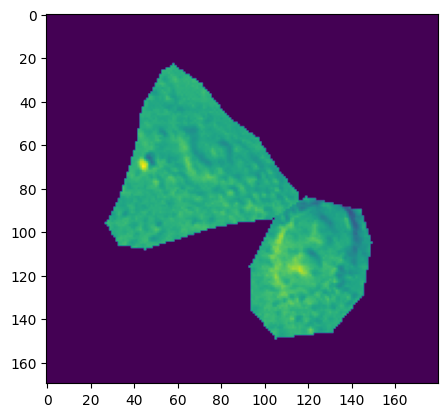

In [32]:
new_sc1, new_sc2, _, _ = gen_synthetic_overlap_scs(sc1, sc2, min_reserved_area_percent=1)
sc3, is_success = merge_two_scs_overlap(new_sc1, new_sc2)
if is_success:
    sc3.show()

In [ ]:
new_sc1, new_sc2, _, _ = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_gauss_sc_bg, min_dist=10, max_dist=50, bg_scale=2, min_reserved_area_percent=1)
sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
if is_success:
    sc3.show()

In [ ]:
new_sc1.show(crop=True)

In [ ]:
new_sc1, new_sc2, _, _ = gen_synthetic_nonoverlap_scs(sc1, sc2, gen_bg_func=gen_sc_bg_crop)
sc3, is_success = merge_two_scs_nonoverlap(new_sc1, new_sc2)
if is_success:
    fig, axes = plt.subplots(1, 4)
    padding = 100
    new_sc1.show_mask(ax=axes[0], crop=True, padding=padding)
    axes[0].set_title("sc1")
    new_sc2.show_mask(ax=axes[1], crop=True, padding=padding)
    axes[1].set_title("sc2")
    sc3.show_mask(ax=axes[2], crop=True, padding=padding)
    axes[2].set_title("sc3")

    axes[3].imshow(new_sc1.get_mask() + new_sc2.get_mask())


In [ ]:
sample_num = 1000

def test_gen_underseg_scs():
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=1)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=1, num_cells=4, total_sample_num=1)

def gen_syn_underseg_data_v6(sample_num=10):
    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)


def gen_syn_nonoverlap_underseg_test_data_v6():
    def _save_all_df(all_df):
        all_df.to_csv(out_dir / "synthetic_underseg_overlap" / "test.csv", index=False)

    subdir = Path("synthetic_underseg_overlap")
    underseg_out_dir = out_dir / subdir
    # generate training data
    sample_num = 100
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)



def gen_syn_nonoverlap_underseg_train_data(gen_bg_func, subdir, sample_num = 10):
    underseg_out_dir = out_dir / subdir
    def _save_all_df(all_df):
        all_df.to_csv(underseg_out_dir / "data.csv", index=False)


    # generate training data
    
    generator_args = {
        "min_dist": 20,
        "max_dist": 70,
        "bg_scale": 5,
        "gen_bg_func": gen_bg_func
    }
    all_df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=0, num_cells=4, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num, num_cells=3, total_sample_num=sample_num, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)
    df = gen_underseg_scs(scs=single_cells, save_dir=underseg_out_dir, sample_id_offset=sample_num * 2, num_cells=2, total_sample_num=sample_num * 2, sc_generator_func=gen_synthetic_nonoverlap_scs, sc_generator_func_kwargs=generator_args, merge_func=merge_two_scs_nonoverlap)
    all_df = pd.concat([all_df, df], ignore_index=True)
    _save_all_df(all_df)


Single core version for testing

In [ ]:
subdir = Path("synthetic_underseg_nonoverlap")
underseg_out_dir = out_dir / subdir
generator_args = {"min_dist": 20, "max_dist": 70, "bg_scale": 3, "gen_bg_func": gen_gauss_sc_bg}
df = gen_underseg_scs(
    scs=single_cells,
    save_dir=underseg_out_dir,
    sample_id_offset=0,
    num_cells=3,
    total_sample_num=3,
    sc_generator_func=gen_synthetic_nonoverlap_scs,
    sc_generator_func_kwargs=generator_args,
    merge_func=merge_two_scs_nonoverlap,
    viz_check=True,
    parallel=False,
)


In [ ]:
gen_syn_nonoverlap_underseg_train_data(gen_bg_func=gen_gauss_sc_bg, subdir=Path("synthetic_underseg_nonoverlap_gauss"))

In [ ]:
# gen_syn_underseg_data_v6(sample_num=1000)
gen_syn_nonoverlap_underseg_test_data_v6()

In [ ]:
gen_underseg_scs(scs=single_cells, total_sample_num=2, save_dir=Path("./notebook_results/tmp/test_v6"), num_cells=4, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=3, viz_check=True)

In [ ]:
# gen_underseg_scs(scs=single_cells, total_sample_num=5, save_dir=None, num_cells=2, viz_check=True)

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
# subdir = Path("synthetic_underseg_overlap")
# overseg_out_dir = out_dir / subdir
# raw_out_dir = overseg_out_dir / "raw"

# # seg_out_dir is the directory containing all raw segmentation masks for training
# # e.g. the eroded raw segmentation masks
# seg_out_dir = overseg_out_dir / "seg"

# # raw_seg_dir is the directory containing all raw segmentation masks for recording purposes
# raw_seg_dir = overseg_out_dir / "raw_seg_crop"
# gt_out_dir = overseg_out_dir / "gt"
# gt_label_out_dir = overseg_out_dir / "gt_label_mask"
# augmented_seg_dir = overseg_out_dir / "augmented_seg"
# raw_transformed_img_dir = overseg_out_dir / "raw_transformed_img"
# augmented_diff_seg_dir = overseg_out_dir / "augmented_diff_seg"
# meta_path = overseg_out_dir / "metadata.csv"

# os.makedirs(raw_out_dir, exist_ok=True)
# os.makedirs(seg_out_dir, exist_ok=True)
# os.makedirs(raw_seg_dir, exist_ok=True)
# os.makedirs(gt_out_dir, exist_ok=True)
# os.makedirs(augmented_seg_dir, exist_ok=True)
# os.makedirs(gt_label_out_dir, exist_ok=True)
# os.makedirs(raw_transformed_img_dir, exist_ok=True)
# os.makedirs(augmented_diff_seg_dir, exist_ok=True)


# overseg_train_path_tuples = []
# augmented_overseg_data = []
# filename_pattern = "img-%d_syn-%d.tif"
# overseg_metadata = []
# underseg_erosion_scale_factors = np.linspace(0, 0.1, 10)
# for sc in tqdm(single_cells):
#     img_id = sc.timeframe
#     for syn_id, overseg_datarow in enumerate(sc.uns[overseg_uns_key]):
#         params = overseg_datarow[1]
#         img_crop = sc.get_contour_img()
#         raw_seg_crop = overseg_datarow[0]
#         eroded_seg_crop = overseg_datarow[1]

#         combined_gt_label_mask = sc.get_contour_mask()
#         assert img_crop.shape == raw_seg_crop.shape == combined_gt_label_mask.shape
#         raw_img_path = raw_out_dir / (filename_pattern % (img_id, syn_id))
#         seg_img_path = seg_out_dir / (filename_pattern % (img_id, syn_id))
#         raw_seg_img_path = raw_seg_dir / (filename_pattern % (img_id, syn_id))
#         gt_img_path = gt_out_dir / (filename_pattern % (img_id, syn_id))
#         gt_label_img_path = gt_label_out_dir / (filename_pattern % (img_id, syn_id))

#         # metadata is a dict, containing params used to genereate our synthetic overseg data
#         meta_info = overseg_datarow[2]
#         meta_info["raw_img_path"] = raw_img_path
#         meta_info["seg_img_path"] = seg_img_path
#         meta_info["gt_img_path"] = gt_img_path
        
#         overseg_metadata.append(meta_info)

#         # call csn augment helper
#         csn_augment_helper(img_crop=img_crop, 
#             seg_crop=eroded_seg_crop, 
#             combined_gt_label_mask=combined_gt_label_mask,
#             overseg_raw_seg_crop=raw_seg_crop,
#             overseg_raw_seg_img_path=raw_seg_img_path,
#             scale_factors=underseg_erosion_scale_factors,
#             train_path_tuples=overseg_train_path_tuples,
#             augmented_data=augmented_overseg_data,
#             img_id=img_id,
#             seg_label=syn_id,
#             gt_label=sc.timeframe,
#             raw_img_path=raw_img_path,
#             seg_img_path=seg_img_path,
#             gt_img_path=gt_img_path,
#             gt_label_img_path=gt_label_img_path,
#             augmented_seg_dir=augmented_seg_dir,
#             augmented_diff_seg_dir=augmented_diff_seg_dir,
#             filename_pattern=filename_pattern,
#         )


Now we need to handle two cases:
1) there is any overlap between two objects  
    a) simply dilate and create underseg cases  
2) there is no overlap (future work) 
    b) fill in the pixels in-between the two objects  
    c) 

## Combine data.csv files generated in each subfolder

In [ ]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [ ]:
len(combined_dataframe)